# Processing L.A. trash collection data

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import datetime as dt

In [3]:
import altair as alt
import altair_latimes as lat
import matplotlib.pyplot as plt

In [4]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Read the collection data

In [5]:
src = pd.read_csv(
    "data/raw/trash.csv",
    parse_dates=[
        "datetime",
    ],
    dtype={
        "year": "str",
        "quarter": "str",
        "day": "str",
        "month": "str",
        "weekday": "str",
    },
)

In [6]:
src.head()

,district,route,datetime,site,ticketnumber,tons,commoditycode,generalcommodity,year,quarter,day,month,weekday,monthname,month_year,days_in_month,apmonth
0,CSLA DCT,LH1,2019-10-01,Republic Sunshine Canyon Landfill,NaN,2.0,H,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
1,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
2,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
3,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
4,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.


In [7]:
codes = pd.read_excel("data/raw/commodity_codes.xlsx")
codes.columns = codes.columns.str.lower().str.replace(" ", "", regex=False)

In [8]:
codes.head()

,commoditycode,commoditydescription
0,OH,OHS Cleanups
1,I,Illegal Dumping/SP
2,H,Washington Crew
3,CB,Commercial Bulky Item
4,C,CARE Teams


### Merge commodity code descriptions into dataframe

In [9]:
df = pd.merge(src, codes, on="commoditycode")

In [10]:
df.head()

,district,route,datetime,site,ticketnumber,tons,commoditycode,generalcommodity,year,quarter,day,month,weekday,monthname,month_year,days_in_month,apmonth,commoditydescription
0,CSLA DCT,LH1,2019-10-01,Republic Sunshine Canyon Landfill,NaN,2.00,H,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.,Washington Crew
1,CSLA DCT,LH1,2019-10-02,Republic Sunshine Canyon Landfill,1266625,0.50,H,Bulky,2019,4,2,10,2,October,2019-10,31,Oct.,Washington Crew
2,CSLA DCT,LH1,2019-10-02,Republic Sunshine Canyon Landfill,1266625,0.64,H,Bulky,2019,4,2,10,2,October,2019-10,31,Oct.,Washington Crew
3,CSLA DCT,LH1,2019-10-02,Republic Sunshine Canyon Landfill,1266625,0.65,H,Bulky,2019,4,2,10,2,October,2019-10,31,Oct.,Washington Crew
4,CSLA DCT,LH2,2019-10-03,Republic Sunshine Canyon Landfill,1267124,1.00,H,Bulky,2019,4,3,10,3,October,2019-10,31,Oct.,Washington Crew


In [11]:
df[df["generalcommodity"] == "Refuse"].commoditycode.unique()

array(['R', 'A', 'D', 'P', 'CA', 'GR'], dtype=object)

In [12]:
df["month_year"] = pd.to_datetime(df["month_year"], format="%Y-%m")

In [13]:
df.sort_values("month")["apmonth"].unique()

array(['Jan.', 'Oct.', 'Nov.', 'Dec.', 'Feb.', 'March', 'April', 'May',
       'June', 'July', 'Aug.', 'Sept.'], dtype=object)

In [14]:
df.year.unique()

array(['2019', '2020', '2021', '2016', '2017', '2018'], dtype=object)

### Annual trash volumn (excluding 2021)

In [15]:
years = ["2019", "2020", "2016", "2017", "2018"]

In [16]:
totals = df[df["year"].isin(years)].groupby(["year"]).agg({"tons": sum}).reset_index()
totals

,year,tons
0,2016,1547453.03
1,2017,1594390.39
2,2018,1570290.11
3,2019,1615392.92
4,2020,1771969.26


### Change in 2020 from mean of previous four years

In [17]:
mean = totals.iloc[0:3]["tons"].mean()

In [18]:
((totals.iloc[4]["tons"] - mean) / mean * 100).round(2)

12.81

### Totals by commodity and year

In [19]:
years_totals = (
    df[df["year"].isin(years)]
    .groupby(["year", "generalcommodity"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)
years_totals

,year,generalcommodity,tons
19,2020,Yard Trimmings,476780.62
18,2020,Refuse,949701.52
17,2020,Recycling,263448.86
16,2020,Bulky,82038.26
15,2019,Yard Trimmings,432255.30
14,2019,Refuse,899871.41
13,2019,Recycling,210421.93
12,2019,Bulky,72844.28
11,2018,Yard Trimmings,412491.80
10,2018,Refuse,883330.24


### Tons per day

In [20]:
years_totals["tons_per_day"] = years_totals["tons"] / 365

In [21]:
area = (
    alt.Chart(years_totals)
    .mark_bar(opacity=0.9)
    .encode(
        x=alt.X(
            "year:O",
            axis=alt.Axis(grid=False),
            title="Month/Year",
        ),
        y=alt.Y(
            "tons:Q",
            axis=alt.Axis(
                format=",.0f",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            title="Tons",
        ),
        color=alt.Color(
            "generalcommodity:N",
            title="Type",
            scale=alt.Scale(scheme="category20"),
        ),
    )
    .properties(width=500, height=400, title="City of L.A. trash totals, by year")
)

(area).configure_view(strokeOpacity=0)

alt.Chart(...)

### Pivot the frame

In [22]:
years_totals_pivot = years_totals.pivot_table(
    columns="year", index="generalcommodity", values="tons_per_day"
).reset_index()

### What's the pct change in tonage from previous year? 

In [23]:
years_totals_pivot["change"] = (
    (years_totals_pivot["2020"] - years_totals_pivot["2019"])
    / years_totals_pivot["2019"]
    * 100
).round(2)

In [24]:
years_totals_pivot

year,generalcommodity,2016,2017,2018,2019,2020,change
0,Bulky,158.042301,177.453562,186.450137,199.573370,224.762356,12.62
1,Recycling,608.314082,601.081370,565.517178,576.498438,721.777699,25.20
2,Refuse,2353.121288,2409.927863,2420.082849,2465.401123,2601.921973,5.54
3,Yard Trimmings,1120.119671,1179.730055,1130.114521,1184.261096,1306.248274,10.30


### Group by years and months

In [25]:
year_grp = (
    df.groupby(["year", "apmonth", "month_year", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)

In [26]:
recycling_year_grp = (
    df[df["generalcommodity"] == "Recycling"]
    .groupby(["year", "apmonth", "month_year", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)

In [27]:
year_grp["tons_per_day"] = (year_grp["tons"] / year_grp["days_in_month"]).round()
recycling_year_grp["tons_per_day"] = (
    recycling_year_grp["tons"] / recycling_year_grp["days_in_month"]
).round()

In [28]:
year_grp = year_grp.sort_values("month_year", ascending=True)

In [29]:
from altair import datum

text = (
    alt.Chart(year_grp.query("tons_per_day == tons_per_day.max()"))
    .mark_text(
        dx=30,
        dy=-15,
        color="#000000",
        font="Benton Gothic",
        fontWeight="bolder",
        fontSize=12,
    )
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
        ),
        y=alt.Y("tons_per_day:Q"),
        text=alt.Text("year"),
    )
)

line = (
    alt.Chart(year_grp)
    .mark_line(interpolate="monotone", size=2)
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
            axis=alt.Axis(grid=False, tickCount=6),
            title=" ",
        ),
        y=alt.Y(
            "tons_per_day",
            axis=alt.Axis(
                format=",.0f",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            scale=alt.Scale(domain=[3000, 6000]),
            title=" ",
        ),
        color=alt.Color(
            "year",
            title=" ",
            scale=alt.Scale(
                domain=["2016", "2017", "2018", "2019", "2020"],
                range=["lightgray", "lightgray", "lightgray", "lightgray", "steelblue"],
            ),
            legend=None,
        ),
    )
)
(line + text).properties(
    width=600, height=400, title="Tons per day (all types) collected"
).configure_view(strokeOpacity=0).configure_axis(labelFontSize=13)

alt.LayerChart(...)

In [30]:
from altair import datum

text = (
    alt.Chart(recycling_year_grp.query("tons_per_day == tons_per_day.max()"))
    .mark_text(
        dx=30,
        dy=-15,
        color="#000000",
        font="Benton Gothic",
        fontWeight="bolder",
        fontSize=12,
    )
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
        ),
        y=alt.Y("tons_per_day:Q"),
        text=alt.Text("year"),
    )
)

line = (
    alt.Chart(recycling_year_grp)
    .mark_line(interpolate="monotone", size=2)
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
            axis=alt.Axis(grid=False, tickCount=6),
            title=" ",
        ),
        y=alt.Y(
            "tons_per_day",
            axis=alt.Axis(
                format=",.0f",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            scale=alt.Scale(domain=[200, 1000]),
            title=" ",
        ),
        color=alt.Color(
            "year",
            title=" ",
            scale=alt.Scale(
                domain=["2016", "2017", "2018", "2019", "2020"],
                range=["lightgray", "lightgray", "lightgray", "lightgray", "steelblue"],
            ),
            legend=None,
        ),
    )
)
(line + text).properties(
    width=600,
    height=400,
    title="Tons per day in (recycling) collected",
).configure_view(strokeOpacity=0).configure_axis(labelFontSize=13)

alt.LayerChart(...)

In [31]:
month_grp = (
    df[df["year"].isin(years)]
    .groupby(["month_year", "year", "month", "generalcommodity", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["month_year"], ascending=False)
)

In [32]:
month_grp["tons_per_day"] = month_grp["tons"] / month_grp["days_in_month"]

In [33]:
month_grp.head()

,month_year,year,month,generalcommodity,days_in_month,tons,tons_per_day
239,2020-12-01,2020,12,Yard Trimmings,31,34938.54,1127.049677
238,2020-12-01,2020,12,Refuse,31,84724.20,2733.038710
237,2020-12-01,2020,12,Recycling,31,23514.86,758.543871
236,2020-12-01,2020,12,Bulky,31,6401.77,206.508710
235,2020-11-01,2020,11,Yard Trimmings,30,37207.13,1240.237667


### Chart it

In [34]:
area = (
    alt.Chart(month_grp)
    .mark_bar(opacity=0.9, size=7)
    .encode(
        x=alt.X(
            "month_year:T",
            axis=alt.Axis(format="%b %Y", grid=False, tickCount=6),
            title="Month/Year",
        ),
        y=alt.Y(
            "tons_per_day:Q",
            axis=alt.Axis(
                format=",.0f",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            title="Tons per day",
        ),
        color=alt.Color(
            "generalcommodity:N",
            title="Type",
            scale=alt.Scale(scheme="category20"),
        ),
    )
    .properties(width=500, height=400, title="City of L.A. trash totals, by year")
)

(area).configure_view(strokeOpacity=0)

alt.Chart(...)

In [35]:
route_commodity_years = (
    df.groupby(["year", "route", "generalcommodity"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by="tons", ascending=False)
)

In [36]:
route_commodity_years.head()

,year,route,generalcommodity,tons
2513,2020,AA3,Refuse,31134.82
2479,2020,AA2,Refuse,30769.86
2543,2020,AA4,Refuse,30269.68
2560,2020,AA7,Refuse,29913.31
2554,2020,AA5,Refuse,29534.81


In [37]:
daily_grp = (
    df.groupby(["datetime", "generalcommodity", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["datetime"], ascending=False)
)

In [38]:
month_grp

,month_year,year,month,generalcommodity,days_in_month,tons,tons_per_day
239,2020-12-01,2020,12,Yard Trimmings,31,34938.54,1127.049677
238,2020-12-01,2020,12,Refuse,31,84724.20,2733.038710
237,2020-12-01,2020,12,Recycling,31,23514.86,758.543871
236,2020-12-01,2020,12,Bulky,31,6401.77,206.508710
235,2020-11-01,2020,11,Yard Trimmings,30,37207.13,1240.237667
...,...,...,...,...,...,...,...
7,2016-02-01,2016,2,Yard Trimmings,29,31317.08,1079.899310
2,2016-01-01,2016,1,Refuse,31,68942.76,2223.960000
1,2016-01-01,2016,1,Recycling,31,18838.48,607.692903
3,2016-01-01,2016,1,Yard Trimmings,31,30707.11,990.551935


In [39]:
alt.Chart(month_grp, title="L.A. trash spiked during pandemic").mark_rect().encode(
    x=alt.X(
        "year(month_year):O",
        axis=alt.Axis(
            tickCount=4, gridColor="#dddddd", offset=6, tickSize=0, domainOpacity=0
        ),
        title=" ",
    ),
    y=alt.Y(
        "month(month_year):O",
        title=" ",
        axis=alt.Axis(
            tickCount=4, gridColor="#dddddd", offset=6, tickSize=0, domainOpacity=0
        ),
    ),
    color=alt.Color(
        "mean(tons_per_day):Q", scale=alt.Scale(scheme="blues"), title="Tons/day"
    ),
).properties(width=320, height=400).configure_view(strokeOpacity=0)

alt.Chart(...)

---

### Routes

In [40]:
df.head()

,district,route,datetime,site,ticketnumber,tons,commoditycode,generalcommodity,year,quarter,day,month,weekday,monthname,month_year,days_in_month,apmonth,commoditydescription
0,CSLA DCT,LH1,2019-10-01,Republic Sunshine Canyon Landfill,NaN,2.00,H,Bulky,2019,4,1,10,1,October,2019-10-01,31,Oct.,Washington Crew
1,CSLA DCT,LH1,2019-10-02,Republic Sunshine Canyon Landfill,1266625,0.50,H,Bulky,2019,4,2,10,2,October,2019-10-01,31,Oct.,Washington Crew
2,CSLA DCT,LH1,2019-10-02,Republic Sunshine Canyon Landfill,1266625,0.64,H,Bulky,2019,4,2,10,2,October,2019-10-01,31,Oct.,Washington Crew
3,CSLA DCT,LH1,2019-10-02,Republic Sunshine Canyon Landfill,1266625,0.65,H,Bulky,2019,4,2,10,2,October,2019-10-01,31,Oct.,Washington Crew
4,CSLA DCT,LH2,2019-10-03,Republic Sunshine Canyon Landfill,1267124,1.00,H,Bulky,2019,4,3,10,3,October,2019-10-01,31,Oct.,Washington Crew


In [41]:
districts_grp = (
    df[df["year"] != "2021"]
    .groupby(["year", "generalcommodity", "district"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)

In [42]:
districts_grp.head()

,year,generalcommodity,district,tons
156,2020,Yard Trimmings,West Valley,133433.91
128,2020,Bulky,South Central,13669.03
136,2020,Recycling,Harbor,12371.71
135,2020,Recycling,East Valley,60545.38
134,2020,Recycling,CSLA Washington,816.04


In [43]:
route_pivot = pd.pivot_table(
    districts_grp,
    columns="year",
    values="tons",
    index=["district"],
    aggfunc={"tons": "sum"},
).reset_index()

In [44]:
route_pivot.columns = route_pivot.columns.astype(str)

In [45]:
before = ["2016", "2017", "2018", "2019"]
after = ["2021"]

In [46]:
route_pivot["before"] = route_pivot[before].mean(axis=1)

In [47]:
route_pivot["change"] = (
    (route_pivot["2020"] - route_pivot["before"]) / route_pivot["before"] * 100
).round(2)

In [48]:
route_pivot[route_pivot["2020"] > 5000].sort_values("change", ascending=False).head(30)

year,district,2016,2017,2018,2019,2020,before,change
0,CSLA DCT,NaN,NaN,NaN,1171.99,5976.72,1171.9900,409.96
8,Receptacles,NaN,NaN,660.73,5692.17,6636.61,3176.4500,108.93
6,Harbor,76774.51,79806.97,75406.82,81676.53,91383.16,78416.2075,16.54
7,North Central,258328.61,264186.84,262640.48,266239.05,293831.09,262848.7450,11.79
9,South Central,311457.52,321421.97,319038.61,326804.25,355695.15,319680.5875,11.27
11,West Valley,316666.84,327902.24,322384.24,330939.60,360822.00,324473.2300,11.20
5,East Valley,339458.54,350072.93,342680.70,348663.14,383502.62,345218.8275,11.09
10,West Los Angeles,235708.34,237401.40,233284.12,234609.30,252816.16,235250.7900,7.47
4,CSLA Washington,9058.67,13598.04,14194.41,14928.04,12027.24,12944.7900,-7.09


---

### Geography

In [49]:
routes = gpd.read_file(
    "data/raw/Sanitation_Maintenance_Districts/Sanitation_Maintenance_Districts.shp"
)

In [50]:
routes.columns = (
    routes.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
)

<AxesSubplot:>

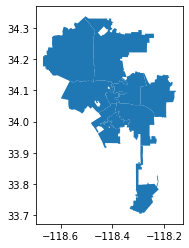

In [51]:
routes.plot()

In [52]:
routes.head(20)

,objectid,name,tooltip,geometry
0,1,RESEDA,District: RESEDA,"POLYGON ((-118.50829 34.33408, -118.50656 34.3..."
1,2,CULVER CITY,District: CULVER CITY,"POLYGON ((-118.38766 34.02913, -118.38729 34.0..."
2,3,HARBOR,District: HARBOR,"POLYGON ((-118.28224 33.92363, -118.28208 33.8..."
3,4,VENICE WESTCHESTER,District: VENICE WESTCHESTER,"POLYGON ((-118.40199 34.05698, -118.40105 34.0..."
4,5,NORTH HOLLYWOOD,District: NORTH HOLLYWOOD,"POLYGON ((-118.50829 34.33408, -118.50397 34.3..."
5,6,NORTH L.A.,District: NORTH L.A.,"POLYGON ((-118.27591 34.15368, -118.27339 34.1..."
6,7,SOUTH L.A.,District: SOUTH L.A.,"POLYGON ((-118.37709 34.05963, -118.37599 34.0..."
7,8,WEST L.A.,District: WEST L.A.,"POLYGON ((-118.56478 34.12979, -118.56311 34.1..."
8,9,HOLLYWOOD,District: HOLLYWOOD,"POLYGON ((-118.36367 34.05811, -118.36514 34.0..."
9,10,BEVERLY HILLS/WEST HOLLYWOOD,District: BEVERLY HILLS/WEST HOLLYWOOD,"POLYGON ((-118.37552 34.08019, -118.37659 34.0..."


---

### Exports

In [53]:
df.to_csv("data/processed/all_data.csv", index=False)

In [54]:
route_pivot.to_csv("data/processed/route_increase.csv", index=False)

In [55]:
month_grp.to_csv("data/processed/month_grp.csv", index=False)

In [56]:
year_grp.to_csv("data/processed/year_grp.csv", index=False)

In [57]:
df.commoditydescription.value_counts()

Refuse                       527086
Yard Trimmings               289071
Recycling                    257148
Regular Bulky                150828
Commercial Refuse             45211
Illegal Dumping/SP            37113
CARE Teams                    32951
White Goods                   16613
Rec. and Parks                15797
E-Waste                       11562
Washington Crew                8202
Dead Animals                   6551
Commercial Recycling           3435
Horse Manure                   2251
A Bridge Home Route            1104
Commercial Yard Trimmings       832
OHS Cleanups                    800
Christmas Tree                  674
Commercial Bulky Item           324
Refuse- Grit                    204
LSD Yard Duty                     1
Name: commoditydescription, dtype: int64